In [1]:
import preamble
from tools.tools import *

import pprint
import feather
import json
import pandas as pd
import numpy as np
import re
from pathlib import Path
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from ipyleaflet import Map, Marker, MarkerCluster, CircleMarker
from ipywidgets import Label, Textarea, VBox
from ipywidgets.embed import embed_minimal_html

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
features = dict()

In [4]:
train = pd.read_csv('../data/train.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

In [5]:
train['isTrain'] = True
test['isTrain'] = False

In [6]:
 missing_values_table(train)

В выбранном датафрейме 8 столбцов.
Всего 3 столбцов с неполными данными.


,Missing Values,% of Total Values
address_rus,304,4.855454
lat,304,4.855454
long,304,4.855454


In [7]:
missing_values_table(test)

В выбранном датафрейме 7 столбцов.
Всего 3 столбцов с неполными данными.


,Missing Values,% of Total Values
address_rus,116,4.632588
lat,116,4.632588
long,116,4.632588


(<Figure size 1296x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3c4697518>)

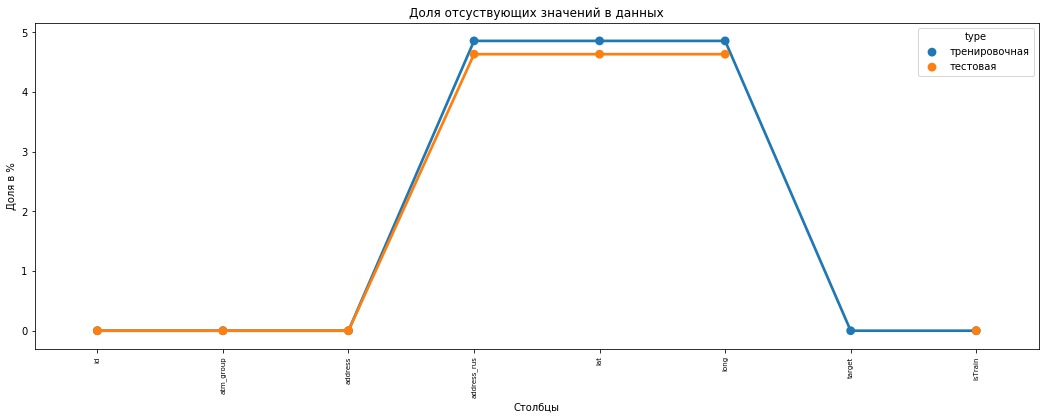

In [8]:
missing_values_plot(train, test)

In [9]:
X = train.append(test, sort=False)

In [10]:
X.reset_index(drop=True, inplace=True)

In [11]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8345.0,54.138304,4.329293,42.057080,52.243997,55.060936,56.116673,69.495093
long,8345.0,63.500873,32.787366,19.941530,37.851107,49.071694,84.950218,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [12]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


Всего 7 идентификаторов банков

In [13]:
missing_values_table(X)

В выбранном датафрейме 8 столбцов.
Всего 4 столбцов с неполными данными.


,Missing Values,% of Total Values
target,2504,28.568169
address_rus,420,4.791786
lat,420,4.791786
long,420,4.791786


In [14]:
X.atm_group.value_counts()

5478.0    3729
1942.0    1646
8083.0    1454
496.5      863
3185.5     826
1022.0     185
32.0        62
Name: atm_group, dtype: int64

In [15]:
train.atm_group.value_counts()

5478.0    2662
1942.0    1160
8083.0    1050
496.5      616
3185.5     594
1022.0     136
32.0        43
Name: atm_group, dtype: int64

In [16]:
test.atm_group.value_counts()

5478.0    1067
1942.0     486
8083.0     404
496.5      247
3185.5     232
1022.0      49
32.0        19
Name: atm_group, dtype: int64

Целевая переменная (индекс популярности геолокации, в которой находится банкомат)

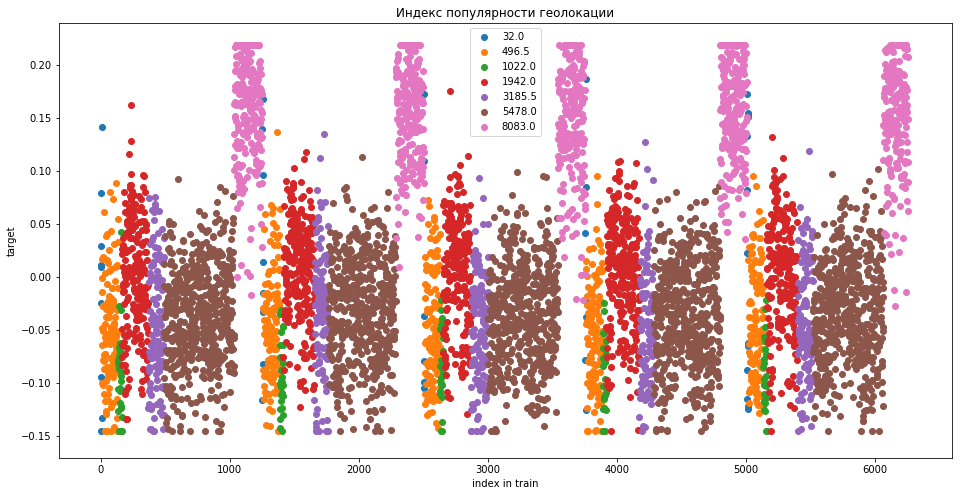

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i, s in enumerate(train.atm_group.unique()):
    tmp = train[train.atm_group == s]
    ax.scatter(tmp.index, tmp.target,label=s)

ax.set(xlabel='index in train',
       ylabel='target',
       title='Индекс популярности геолокации')

ax.legend(loc=0)
fig.show()

Не заполнены значения широты, долготы и адреса для 420 банкоматов 

In [18]:
unknown = X[X['lat'].isnull() & X['long'].isnull() & X['address_rus'].isnull()]
unknown.shape

(420, 8)

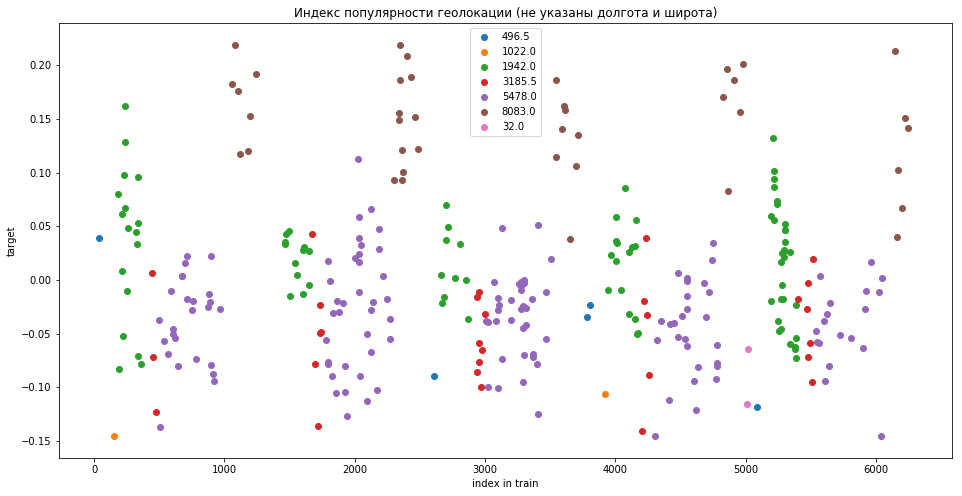

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i, s in enumerate(unknown.atm_group.unique()):
    tmp = unknown[unknown.atm_group == s]
    ax.scatter(tmp.index, tmp.target,label=s)

ax.set(xlabel='index in train',
       ylabel='target',
       title='Индекс популярности геолокации (не указаны долгота и широта)')

ax.legend(loc=0)
fig.show()

Самые "плохие", "хорошие" и средние банкоматы. Цветом обозначены различные `atm_group`.

In [20]:
m = Map(center=[X.lat.mean(), X.long.mean()], zoom=3)

atm_colors = ['cyan', 'skyblue', 'yellow', 'orange', 'tan', 'lime', 'tomato']
# num = X.shape[0]
num = 10

for a, c in tqdm(zip(list(X.atm_group.value_counts().index), atm_colors)):
    green = (
        (X['target'] >= X.describe()['target']
         ['75%']) & (X['atm_group'] == a)
    )
    for loc in X[['lat', 'long']][green].dropna().iloc[:num, :].values:
        m += CircleMarker(location=list(loc), color="green", fill_color=c,
                          opacity=1, fill_opacity=0.8, radius=6, weight=2)

    blue = (
        (X['target'] < X.describe()['target']['75%'])
        & (X['target'] > X.describe()['target']['25%'])
        & (X['atm_group'] == a)
    )
    for loc in X[['lat', 'long']][blue].dropna().iloc[:num, :].values:
        m += CircleMarker(location=list(loc), color="blue", fill_color=c,
                          opacity=1, fill_opacity=0.8, radius=6, weight=2)

    red = (
        (X['target'] <= X.describe()['target']
         ['25%']) & (X['atm_group'] == a)
    )
    for loc in X[['lat', 'long']][red].dropna().iloc[:num, :].values:
        m += CircleMarker(location=list(loc), color="red", fill_color=c,
                          opacity=1, fill_opacity=0.8, radius=6, weight=2)
    
    black = X['target'].isna()
    for loc in X[['lat', 'long']][black].dropna().iloc[:num, :].values:
        m += CircleMarker(location=list(loc), color="gray", fill_color=c,
                          opacity=0.4, fill_opacity=0.4, radius=6, weight=2)

text = Textarea(layout={'width': '95%', 'height': '95%'})
box = VBox([text], layout={'width': '800px', 'height': '300px'})

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'click':
        lat, long = kwargs.get('coordinates')
        s = X[(X['lat'] == lat) & (X['long'] == long)]
        text.value = pprint.pformat(s.to_dict(), width=250)

m.on_interaction(handle_interaction)
embed_minimal_html('../workspace/map.html', views=[m], title='Widgets export')

7it [00:03,  2.18it/s]


In [21]:
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [22]:
display(box)

Партнеры РОСБАНКА:

- Альфа-Банк
- Райффайзенбанк
- ВТБ
- Россельхозбанк
- УРАЛСИБ БАНК
- Газпромбанк
- АК Барс

Похоже, что `atm_group`:

- `5478.0` (3729) ВТБ
- `1942.0` (1646) Альфа-Банк
- `8083.0` (1454) РОСБАНК
- `496.5` (863) Россельхозбанк
- `3185.5` (826) Газпромбанк
- `1022.0` (185) АК Барс
- `32.0` (62) УРАЛСИБ БАНК

### Подсказки от организаторов

    Александр Мамаев
    Все ответы одним постом:
    1.  Все банкоматы из одного временного интервала, находились в одной геопозиции
        на протяжении всего времени сбора исходных данных необходимых для расчета
        таргета.
    2.  В системах банка адрес банкомата хранится в виде поля address. Поля
        address_rus, lat, long - восстанавливались на основе поля address. Для части
        банкоматов адрес и местоположение с точностью до дома установить не удалось.
        Но если взять поисковик на букву 'Г' (или любой другой до  'Я' включительно)
        и ввести в него значения поля address можно получить представление о той
        технологии с помощью которой поля заполнялись.  Облегчить процесс
        представления может помочь  "import selenium".
    3.  Id формировался на основе atm_group и уникального внутри каждой группы id
        банкомата. X.sort_values('id') даст Вам понимание его структуры. Самыми
        высокими индексами популярности обладает  группа банкоматов "Росбанка".
        Остальные группы - банкоматы банков партнёров.
    4.  Таргет - функция от объективных показателей связанных с количеством операций
        совершаемых на устройстве в единицу времени.
    5.  PSI таргета между train/test/private во всех попарных комбинациях меньше
        0.05. 
    6.  Статистические тесты Манна-Уитни о равенстве средних не отвергают нулевые
        гипотезы для всех попарных комбинаций  train/test/private.
    7.  Таргет обрезан сверху для удаления из выборки банкоматов, чья популярность не
        объясняется геолокацией банкомата.  
    8.  Разделение train/test/private. Если посмотреть на индексы популярности
        банкоматов стоящих по одному адресу, то можно увидеть, что они очень близки.
        Пересечение множетсв адресов в private  и traine привело бы к лику.  Можно
        конечно было бы сгруппировать все банкоматы стоящие по одному адресу в один
        объект обучающей выборки и уйти от проблемы.  Ничто не мешает Вам и сейчас
        поступить подобным образом, после некоторых преобразований на targete.
    9.  Визуализация карт. https://pypi.org/project/folium/
    10. По поводу точности определения адресов.  Я думаю масштаб проблемы несколько
        преувеличен. Если воспользоваться примером кода по ссылке, случайно
        найденным мной в интернете, и дописать к нему еще несколько эвристик, можно
        значительно повысить точность определения адресов.
        https://github.com/aamamaev/machine-learning/tree/master/parsing
    11. По поводу адресов на латинице.  Для банкоматов банков партнёров есть только
        латынь, содержащаяся в транзакционных данных.  Адреса на латыни никто
        специально не обрезал.  Если не хочется восстанавливать адреса, можно
        заняться написанием эффективного парсера или генерацией  оригинальных
        геопризнаков. Номинации в контесте на любой вкус.

---

### Преобразуем `atm_group` one_hot_encoding

In [23]:
features['atm_group_dummies'] = (
    pd.get_dummies(
        X[['id', 'atm_group']],
        columns=['atm_group']
    )
)

### Количество банкоматов стоящих по одному адресу

In [24]:
feature_address_ru_count = (
    X.merge(
        (
            X.groupby('address_rus')
            .size()
            .to_frame('address_ru_count')
            .reset_index()
        ),
        on='address_rus',
        how='left',
        validate='many_to_one'
    )
    .loc[:, ['id', 'address_ru_count']]
    .fillna(-1)
)

features['address_ru_count'] = feature_address_ru_count

In [25]:
feature_address_ru_count.describe()

,id,address_ru_count
count,8765.000000,8765.000000
mean,4404.586366,1.673132
std,2542.532548,1.307586
min,1.000000,-1.000000
25%,2207.000000,1.000000
50%,4403.000000,1.000000
75%,6603.000000,2.000000
max,8811.000000,10.000000


In [26]:
# counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count_in_address_ru'})
# X = pd.merge(X, counts, how='left', on='address_rus')

### Количество банкоматов стоящих по одному адресу (en)

In [27]:
feature_address_en_count = (
    X.merge(
        (
            X.groupby('address')
            .size()
            .to_frame('address_en_count')
            .reset_index()
        ),
        on='address',
        how='left',
        validate='many_to_one'
    )
    .loc[:, ['id', 'address_en_count']]
    .fillna(-1)
)

features['address_en_count'] = feature_address_en_count

In [28]:
feature_address_en_count.describe()

,id,address_en_count
count,8765.000000,8765.000000
mean,4404.586366,1.449971
std,2542.532548,0.935220
min,1.000000,1.000000
25%,2207.000000,1.000000
50%,4403.000000,1.000000
75%,6603.000000,1.000000
max,8811.000000,7.000000


In [29]:
# counts = X.groupby('address')['id'].count().reset_index().rename(columns={'id':'count_in_address_en'})
# X = pd.merge(X, counts, how='left', on='address')

### Количество банкоматов стоящих по одним координатам

In [30]:
feature_locations_count = (
    X.merge(
        (
            X.groupby(['lat', 'long'])
            .size()
            .to_frame('locations_count')
            .reset_index()
        ),
        on=['lat', 'long'],
        how='left',
        validate='many_to_one'
    )
    .loc[:, ['id', 'locations_count']]
    .fillna(-1)
)

features['locations_count'] = feature_locations_count

In [31]:
feature_locations_count.describe()

,id,locations_count
count,8765.000000,8765.000000
mean,4404.586366,1.673132
std,2542.532548,1.307586
min,1.000000,-1.000000
25%,2207.000000,1.000000
50%,4403.000000,1.000000
75%,6603.000000,2.000000
max,8811.000000,10.000000


In [32]:
# counts = X.groupby(['lat', 'long'])['id'].count().reset_index().rename(columns={'id':'count_in_cords'})
# X = pd.merge(X, counts, how='left', on=['lat', 'long'])

### Расстояния до ближайших банкоматов

In [33]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [34]:
knc = KNeighborsClassifier(metric=distance)

In [35]:
dots = X[['lat','long']].dropna()

In [36]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7fd38d8e92f0>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [38]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [39]:
features['self_distances'] = (
    pd.concat([X, dots.drop(columns=['lat', 'long'])], axis=1)
    .loc[:, (
        ['id'] +
        list(dots.columns[dots.columns.str.contains('distance')]) +
        list(dots.columns[dots.columns.str.contains('indexes')])
    )]
)

### Город размещения

In [40]:
address_rare_city = X[['id', 'address_rus']].loc[:]

address_rare_city['address_ru_city'] = (
    address_rare_city[
        ~address_rare_city.address_rus.isnull()
    ].address_rus.apply(
        lambda x: x.split(',')[2]
    )
)

rare_cities = (
    address_rare_city['address_ru_city']
    .value_counts()[
        (address_rare_city['address_ru_city'].value_counts() < 20)
    ].index
)

address_rare_city['rare_address_ru_city'] = (
    address_rare_city['address_ru_city'].apply(
        lambda x: 'RARE' if x in rare_cities else x
    )
)

address_rare_city['rank_rare_address_ru_city'] = address_rare_city['rare_address_ru_city'].rank().fillna(-1)
features['rare_address_ru_city'] = address_rare_city[['id', 'rank_rare_address_ru_city']]

In [41]:
(
    address_rare_city[address_rare_city['rare_address_ru_city'] == 'RARE']
    .groupby('address_ru_city')
    .size()
    .to_frame('count')
    .sort_values(by='count', ascending=False)
    .reset_index()
    .head(10)
)

,address_ru_city,count
0,Магадан,19
1,Альметьевск,19
2,Магнитогорск,18
3,Орёл,17
4,Ленинский район,16
5,Биробиджан,16
6,Архангельск,16
7,Новороссийск,16
8,микрорайон Северный,15
9,Химки,15


In [42]:
(
    address_rare_city[address_rare_city['rare_address_ru_city'] != 'RARE']
    .groupby('address_ru_city')
    .size()
    .to_frame('count')
    .sort_values(by='count', ascending=False)
    .reset_index()
    .head(10)
)

,address_ru_city,count
0,Москва,776
1,Санкт-Петербург,238
2,Новосибирск,204
3,Красноярск,190
4,Омск,150
5,Владивосток,142
6,Томск,128
7,Нижний Новгород,123
8,Самара,121
9,Барнаул,120


### Расстояния до различных географических объектов

А есть ли зависимость оценки местоположения банкомата от окружающих объектов инфраструктуры?
Например, ести банкомат стоит в большом магазине, или на вокзале?

In [43]:
def dot_distances(dots_source, dots_target, n_distances = 6, farthest = False, geo_object_name = 'geo'):
    """Находим расстояния от каждой точки (lat, long) из массива dots_source
    до каждой точки массива dots_target и возвращаем n_distances первых.
    
    :param dots_source: 
    :param dots_target: 
    :param n_distances: 
    :param farthest:
    :param geo_object_name:
    """
    distances = list()

    source = dots_source[['lat', 'long']].iloc[:]
    target = dots_target[['lat', 'long']].iloc[:]

    # Для каждой точки вычисляем расстояния до всех геообъектов

    for i, d in enumerate(list(source.values)):
        dot_object_distances = list()
        for p in list(target.values):
            dot_object_distances.append(distance(d, p))
        distances.append(sorted(dot_object_distances, reverse=farthest)[:n_distances])

    # каждая строка distances содержит отсортированный массив расстояний от
    # каждой точки до n_distances первых геообъектов.

    distances_stacked = np.column_stack(distances)

    # distances_stacked первая строка содержит первые ближайшие расстояния
    # от каждой точки до геообъекта, вторая - вторые, и т.д.

    for i in range(0, n_distances):
        source['dist_{}_{}'.format(geo_object_name, i)] = distances_stacked[i]
        
    return source

In [44]:
def load_overpass_data2(name, dots_source, tags):
    """Загружаем данные (в формате json), полученные с помощью Overpass API и
    вычисляем расстояния от каждой точки dots_source.

    :param name: название загружаемых географических объектов
    :param dots_source: pandas.DataFrame, содержащий координаты исходных точек
    :param tags: поля, загружаемые из словаря tags
    """
    
    osm_node_file = '../workspace/osm_node_{}.json'.format(name)
    osm_way_file = '../workspace/osm_way_{}.json'.format(name)
    cache_file = '../workspace/{}_distances.feather'.format(name)
    cache = Path(cache_file)
    
    a = list()
    for file in [osm_node_file, osm_way_file]:
        if not Path(file).is_file():
            continue
            
        with open(file) as f:
            json_data = json.load(f)
            for e in json_data['elements']:
                if e['type'] == 'node':
                    a.append(
                        [e['lat'], e['lon']] +
                        [e['tags'].get(t) for t in tags]
                    )
                else:
                    a.append(
                        [e['center']['lat'], e['center']['lon']] +
                        [e['tags'].get(t) for t in tags]
                    )

    columns = ['lat', 'long'] + tags
    dots_target = pd.DataFrame(a, columns=columns)

    distances = pd.DataFrame()
    if cache.is_file():
        distances = feather.read_dataframe(cache_file)
    else:
        distances = dot_distances(
            dots_source,
            dots_target,
            geo_object_name=name
        )
        distances.to_feather(cache_file)

    return distances, dots_target

In [45]:
# Оставлено как пример
#
# file = Path('../workspace/police_distances.feather')

# if file.is_file():
#     police_distances = feather.read_dataframe(str(file))
# else:
#     with open('../workspace/osm_amenity_police.json') as f:
#         police = json.load(f)
#     print('Полицейских участков: {}'.format(len(police['elements'])))

#     a = list()
#     for e in police['elements']:
#         name = None
#         if 'name' in e['tags'].keys():
#             name = e['tags']['name']
#         a.append([e['lat'], e['lon'], e['tags']['amenity'], name])
        
#     police = pd.DataFrame(a, columns=['lat', 'long', 'amenity', 'name'])
#     police_distances = dot_distances(X, police, geo_object_name='police')
#     police_distances.to_feather(str(file))
    
# X = pd.concat([X, police_distances.drop(columns=['lat', 'long'])], axis=1)

Получить список объектов можно через Overpass API.

In [46]:
%%bash
../scripts/10-places.sh


[out:json];
area['ISO3166-1'=RU][admin_level=2];
(
node[shop=mall](area);
);
out center;
----------------------------------------------------

[out:json];
area['ISO3166-1'=RU][admin_level=2];
(
way[shop=mall](area);
relation[shop=mall](area);
);
out center;
----------------------------------------------------

[out:json];
area['ISO3166-1'=RU][admin_level=2];
(
node[shop=supermarket](area);
);
out center;
----------------------------------------------------

[out:json];
area['ISO3166-1'=RU][admin_level=2];
(
way[shop=supermarket](area);
relation[shop=supermarket](area);
);
out center;
----------------------------------------------------

[out:json];
area['ISO3166-1'=RU][admin_level=2];
(
node[shop=department_store](area);
);
out center;
----------------------------------------------------

[out:json];
area['ISO3166-1'=RU][admin_level=2];
(
way[shop=department_store](area);
relation[shop=department_store](area);
);
out center;
----------------------------------------------------

[out:j

Результаты записываются в папке `workspace`

In [47]:
%ls ../workspace/osm*

../workspace/osm_node_aeroway_terminal.json
../workspace/osm_node_alcohol.json
../workspace/osm_node_atm.json
../workspace/osm_node_bank.json
../workspace/osm_node_city.json
../workspace/osm_node_department_store.json
../workspace/osm_node_mall.json
../workspace/osm_node_police.json
../workspace/osm_node_post_office.json
../workspace/osm_node_railway_station.json
../workspace/osm_node_station.json
../workspace/osm_node_supermarket.json
../workspace/osm_node_town.json
../workspace/osm_node_university.json
../workspace/osm_way_aeroway_terminal.json
../workspace/osm_way_alcohol.json
../workspace/osm_way_atm.json
../workspace/osm_way_bank.json
../workspace/osm_way_department_store.json
../workspace/osm_way_mall.json
../workspace/osm_way_police.json
../workspace/osm_way_post_office.json
../workspace/osm_way_railway_station.json
../workspace/osm_way_station.json
../workspace/osm_way_supermarket.json
../workspace/osm_way_university.json


Там же находятся файлы с уже вычисленными расстояниями `*.feather`

In [48]:
%ls ../workspace/*.feather

../workspace/aeroway_terminal_distances.feather
../workspace/alcohol_distances.feather
../workspace/atm_distances.feather
../workspace/atms_in_the_same_location.feather
../workspace/atms_in_the_same_location_one_col.feather
../workspace/bank_distances.feather
../workspace/city_distances.feather
../workspace/department_store_distances.feather
../workspace/distances_targets.feather
../workspace/mall_distances.feather
../workspace/police_distances.feather
../workspace/post_office_distances.feather
../workspace/railway_station_distances.feather
../workspace/station_distances.feather
../workspace/supermarket_distances.feather
../workspace/town_distances.feather
../workspace/university_distances.feather


In [49]:
names = [
    'police', 'bank', 'atm', 'post_office', 'university', 'city', 'town',
    'mall', 'supermarket', 'department_store', 'alcohol', 'station', 'railway_station',
    'aeroway_terminal'
]
tags = ['name', 'amenity', 'atm', 'population']
geo_distances = dict()
geo_data = dict()
for name in tqdm(names):
    distances, overpass_data = load_overpass_data2(name, X, tags)
    distances = distances.fillna(-1)
    geo_distances[name] = distances
    geo_data[name] = overpass_data

geo_distances.keys()

100%|██████████| 14/14 [00:01<00:00,  8.57it/s]


dict_keys(['police', 'bank', 'atm', 'post_office', 'university', 'city', 'town', 'mall', 'supermarket', 'department_store', 'alcohol', 'station', 'railway_station', 'aeroway_terminal'])

Добавляем среднее расстояние до объектов и присоединяем к `X`

In [50]:
for d in geo_distances.keys():
    dist_columns = geo_distances[d].columns.str.contains('dist')
    mean_column = 'dist_{}_mean'.format(d)
    min_column = 'dist_{}_min'.format(d)
    max_column = 'dist_{}_max'.format(d)
    std_column = 'dist_{}_std'.format(d)
    
    geo_distances[d][mean_column] = geo_distances[d].iloc[:,dist_columns].mean(axis=1)
    geo_distances[d][min_column] = geo_distances[d].iloc[:,dist_columns].min(axis=1)
    geo_distances[d][max_column] = geo_distances[d].iloc[:,dist_columns].max(axis=1)
    geo_distances[d][std_column] = geo_distances[d].iloc[:,dist_columns].std(axis=1)
    
#     X = pd.concat([X, geo_distances[d].drop(columns=['lat', 'long'])], axis=1)

In [51]:
for d in geo_distances.keys():
    features['distances_%s' % d] = (
        pd.concat([X, geo_distances[d].drop(columns=['lat', 'long'])], axis=1)
        .loc[:, (
            ['id'] +
            list(
                geo_distances[d].columns[
                    geo_distances[d].columns.str.contains('dist')
                ]
            )
        )]
    )

### Расстояние от каждого банкомата до  всех других

In [52]:
%ls -lha ../workspace/distances_targets.feather

-rw-r--r-- 1 axl axl 2,0M Jan  4 00:10 ../workspace/distances_targets.feather


In [53]:
def distance_target(dots):
    """Находми расстояния до ближайших банкоматов, их target и atm_group.
    
    :param dots: входные данные
    """
    distances = list()
    targets = list()
    atm_groups = list()

    cache_file = '../workspace/distances_targets.feather'
    cache = Path(cache_file)
    
    source = dots[['lat', 'long']].iloc[:]
    target = dots[['lat', 'long']].iloc[:]

    if cache.is_file():
        return feather.read_dataframe(cache_file)
    
    for i, d in enumerate(list(source.values)):
        dot_object_distances = list()

        for p in list(target.values):
            dot_object_distances.append(distance(d, p))

        d1 = pd.DataFrame(dot_object_distances, index=target.index, columns=['dist'])
        d1 = d1.sort_values(by=['dist']).iloc[1:10, :]
        d1 = d1.join(X, how='left').loc[:, ['dist', 'target', 'atm_group']]

        distances.append(list(d1['dist'].values))
        targets.append(list(d1['target'].values))
        atm_groups.append(list(d1['atm_group'].values))

    distances_stacked = np.column_stack(distances)
    targets_stacked = np.column_stack(targets)
    atm_groups_stacked = np.column_stack(atm_groups)

    for i in range(0, 9):
        source['dist_{}_{}'.format('nearest', i)] = distances_stacked[i]
        source['targ_{}_{}'.format('nearest', i)] = targets_stacked[i]
        source['atmg_{}_{}'.format('nearest', i)] = atm_groups_stacked[i]
    
    result = pd.concat([dots[['lat', 'long']], source.drop(columns=['lat', 'long'])], axis=1)
    result.to_feather(cache_file)
    return result

In [54]:
nearest_atms = distance_target(X)

# С этими признаками модель очень сильно прееобучается. При обучении результат
# 0.42, на public 0.46

# features['nearest_distance_target'] = (
#     pd.concat([X, nearest_atms.drop(columns=['lat', 'long'])], axis=1)
#     .loc[:, (
#         ['id'] +
#         list(
#             nearest_atms.columns[
#                 nearest_atms.columns.str.contains('nearest')
#             ]
#         )
#     )]
# )

### Банкоматы в одном и том же мести (в радиусе 10 метров)

In [55]:
%ls -lha ../workspace/atms_in_the_same_location.feather
# %rm ../workspace/atms_in_the_same_location.feather

-rw-r--r-- 1 axl axl 4,2M Jan  4 16:44 ../workspace/atms_in_the_same_location.feather


In [56]:
def atms_in_the_same_location(data):
    """Банкоматы, стоящие в одном месте (радиус 10 метров).
    
    Стоящие рядом банкоматы кодируются отдельным столбцом со значениями
    "True" в соответствующих строках.
    """
    cache_file = '../workspace/atms_in_the_same_location.feather'
    cache = Path(cache_file)

    out = data[['id']].iloc[:]
    source = data[['lat', 'long']].iloc[:]
    target = data[['lat', 'long']].iloc[:]

    if cache.is_file():
        return feather.read_dataframe(cache_file)

    for i, d in tqdm(enumerate(list(source.values)), total=source.shape[0]):
        dot_object_distances = list()

        for p in list(target.values):
            dot_object_distances.append(distance(d, p))

        d1 = pd.DataFrame(
            dot_object_distances,
            index=target.index,
            columns=['dist']
        )
        d1 = d1[d1['dist'] < 0.01]
        d1 = d1.join(out, how='left').loc[:, ['id']]
        if d1.shape[0] > 1:
            location = 'same_loc_%s' % i
            out.at[out['id'].isin(d1['id']), location] = True
            out[location] = out[location].fillna(False)

    out.to_feather(cache_file)
    return out

In [57]:
atms_location = atms_in_the_same_location(X)
features['atms_in_the_same_location'] = atms_location

In [58]:
features['atms_in_the_same_location'].shape

(8765, 3620)

### Средняя оценка места размещения банкоматов

В радиусе 10 метров.

In [59]:
%ls -lha ../workspace/atms_in_the_same_location_one_col.feather
# %rm ../workspace/atms_in_the_same_location_one_col.feather

-rw-r--r-- 1 axl axl 276K Jan  4 17:30 ../workspace/atms_in_the_same_location_one_col.feather


In [60]:
def atms_in_the_same_location2(data):
    """Находим банкоматы, стоящие в одном месте и вычисляем среднюю оценку для них."""
    cache_file = '../workspace/atms_in_the_same_location_one_col.feather'
    cache = Path(cache_file)

    out = data[['id', 'target']].iloc[:]
    source = data[['lat', 'long']].iloc[:]
    target = data[['lat', 'long']].iloc[:]
    location_column = 'same_loc'
    target_mean_column = 'target_mean'
    
    if cache.is_file():
        return feather.read_dataframe(cache_file)

    for i, d in tqdm(enumerate(list(source.values)), total=source.shape[0]):
        dot_object_distances = list()

        for p in list(target.values):
            dot_object_distances.append(distance(d, p))

        d1 = pd.DataFrame(
            dot_object_distances,
            index=target.index,
            columns=['dist']
        )
        d1 = d1[d1['dist'] < 0.01]
        d1 = d1.join(out, how='left').loc[:, ['id', 'target']]
        if d1.shape[0] > 1:
            out.at[out['id'].isin(d1['id']), location_column] = i
            out.at[out['id'].isin(d1['id']), target_mean_column] = d1['target'].mean()

    out[location_column] = out[location_column].fillna(-1)
    out[target_mean_column] = out[target_mean_column].fillna(-1)
    out.to_feather(cache_file)
    return out

In [61]:
atms_location_col = atms_in_the_same_location2(X)
features['atms_in_the_same_location2'] = atms_location_col[['id', 'same_loc', 'target_mean']]

In [62]:
features['atms_in_the_same_location2'].describe()

,id,same_loc,target_mean
count,8765.000000,8765.000000,8765.000000
mean,4404.586366,2223.245636,-0.646282
std,2542.532548,3089.170838,0.486608
min,1.000000,-1.000000,-1.000000
25%,2207.000000,-1.000000,-1.000000
50%,4403.000000,-1.000000,-1.000000
75%,6603.000000,4790.000000,-0.031505
max,8811.000000,8763.000000,0.218608


### Адреса точек из OSM

In [63]:
def load_osm_reverse_addresses():
    osm_reverse_address_file = '../workspace/reverce_addresses.json'
    addresses = list()
    
    with open(osm_reverse_address_file) as f:
        json_data = json.load(f)

    for k in json_data.keys():
        e = json_data[k]
        a = e.get('address')
        city = a.get('city')
        if city is None:
            city = a.get('town')
        if city is None:
            city = a.get('village')
        if city is None:
            city = a.get('hamlet')
        if city is None:
            city = a.get('suburb')
        if city is None:
            city = a.get('county')
        addresses.append([
            e.get('record_id'),
            e.get('category'),
            e.get('type'),
            e.get('place_rank'),
            a.get('house_number'),
            a.get('road'),
            a.get('suburb'),
            city,
            a.get('county'),
            a.get('state'),
        ])

    columns = ['record_id', 'category', 'type', 'place_rank', 
               'house_number', 'road', 'suburb', 'city', 'county', 'state']
    reverce_addresses = pd.DataFrame(addresses, columns=columns)
    
    return json_data, reverce_addresses

In [64]:
json_data, reverce_addresses = load_osm_reverse_addresses()
reverce_addresses.at[reverce_addresses['state'] == 'ЦФО', 'city'] = 'Москва'
reverce_addresses.at[reverce_addresses['state'] == 'Санкт-Петербург', 'city'] = 'Санкт-Петербург'

In [65]:
reverce_addresses.shape

(8345, 10)

In [66]:
reverce_addresses.describe(include='all')

,record_id,category,type,place_rank,house_number,road,suburb,city,county,state
count,8345.000000,8345,8345,8345,7047,7937,4680,8345,7161,8345
unique,NaN,12,134,8,934,2237,966,1016,801,81
top,NaN,building,yes,30,1,улица Ленина,Центр,Москва,городской округ Красноярск,ЦФО
freq,NaN,4939,4961,7731,257,338,111,832,229,832
mean,4412.909227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2542.997777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2226.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4401.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,6605.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
missing_values_table(reverce_addresses)

В выбранном датафрейме 10 столбцов.
Всего 4 столбцов с неполными данными.


,Missing Values,% of Total Values
suburb,3665,43.918514
house_number,1298,15.554224
county,1184,14.188137
road,408,4.889155


### Тип места OSM

Для каждого адреса в OSM есть пометки `place_rank`, `category`, `type`. Первая означает [некий](https://stackoverflow.com/questions/20972355/openstreetmap-response-importance-and-place-rank-fields/20974085#20974085) "ранг" места, вторая и третья характеризуют место размещения

In [68]:
feature_osm_place_type = pd.get_dummies(
    reverce_addresses[['record_id', 'place_rank', 'category', 'type']], 
    columns=['place_rank', 'category', 'type']
)

features['osm_place_type'] = (
    feature_osm_place_type.rename(columns={'record_id': 'id'})
)

### Город размещения OSM

In [69]:
osm_rare_city = reverce_addresses[['record_id', 'city']].loc[:]

rare_cities = osm_rare_city['city'].value_counts()[osm_rare_city['city'].value_counts() < 20].index

osm_rare_city['rare_city_osm'] = osm_rare_city['city'].apply(lambda x: 'RARE' if x in rare_cities else x)

osm_rare_city['rank_rare_city_osm'] = osm_rare_city['rare_city_osm'].rank().fillna(-1)

features['osm_rare_city'] = (
    osm_rare_city[['record_id', 'rank_rare_city_osm']].rename(columns={'record_id': 'id'})
)

osm_rare_city.describe(include='all')

,record_id,city,rare_city_osm,rank_rare_city_osm
count,8345.000000,8345,8345,8345.000000
unique,NaN,1016,82,NaN
top,NaN,Москва,RARE,NaN
freq,NaN,832,2360,NaN
mean,4412.909227,NaN,NaN,4173.000000
std,2542.997777,NaN,NaN,2380.363721
min,1.000000,NaN,NaN,1180.500000
25%,2226.000000,NaN,NaN,1180.500000
50%,4401.000000,NaN,NaN,4125.000000
75%,6605.000000,NaN,NaN,6219.500000


In [70]:
(
    osm_rare_city[osm_rare_city['rare_city_osm'] == 'RARE']
    .groupby('city')
    .size()
    .to_frame('count')
    .sort_values(by='count', ascending=False)
    .reset_index()
    .head(10)
)

,city,count
0,Магадан,19
1,Магнитогорск,18
2,Химки,18
3,Биробиджан,17
4,Орёл,17
5,Красногорск,17
6,Новороссийск,17
7,Северодвинск,15
8,Саранск,15
9,Волжский,15


In [71]:
(
    osm_rare_city[osm_rare_city['rare_city_osm'] != 'RARE']
    .groupby('city')
    .size()
    .to_frame('count')
    .sort_values(by='count', ascending=False)
    .reset_index()
    .head(10)
)

,city,count
0,Москва,832
1,Санкт-Петербург,263
2,Красноярск,229
3,Новосибирск,222
4,Омск,184
5,Екатеринбург,146
6,Владивосток,146
7,Томск,137
8,Самара,130
9,Нижний Новгород,130


### Уточняем данные о банкоматах с сайта Росбанка

In [72]:
%ls -lha ../workspace/rosbank_atm.json
# %rm ../workspace/rosbank_atm.json

-rw-rw-r-- 1 axl axl 40M Jan  3 20:16 ../workspace/rosbank_atm.json


In [73]:
# %bash ../scripts/30-rosbank-atm.py

In [74]:
rosbank_atm_file = '../workspace/rosbank_atm.json'

rows = list()
columns = ['region', 'city', 'bank', 'address_title', 'address_type', 
           'working_time', 'currency', 'address_metro', 'long', 'lat']

if Path(rosbank_atm_file).is_file():
    with open(rosbank_atm_file) as f:
        rosbank_atms = json.load(f)
        
for atm in rosbank_atms:
    rows.append([atm[c] for c in columns])

atms = pd.DataFrame(rows, columns=columns)

In [75]:
atms.head(3).T

,0,1,2
region,Алтайский край,Алтайский край,Алтайский край
city,Барнаул,Барнаул,Барнаул
bank,Росбанк,Росбанк,Росбанк
address_title,Тракт Павловский 192А,Улица Никитина 76а,
address_type,"Гипермаркет ""Леруа Мерлен""",отделение,ТЦ Пионер
working_time,Пн-Вс:08:00-22:00,"Пн-Пт:09:00-20:00, Cб:10:00-17:00",Пн-Вс:08:00-02:00
currency,Выдача (₽)\nЧасть операций недоступна,"Выдача (₽, $, €)\nВнесение\nЧасть операций нед...",Выдача (₽)\nВнесение
address_metro,,,
long,83.632452,83.790628,83.764055
lat,53.350284,53.336436,53.36228


In [76]:
atms.bank.unique()

array(['Росбанк', 'Альфабанк', 'Райффайзен-банк', 'УРАЛСИБ Банк',
       'АК БАРС', 'Россельхозбанк', 'Газпромбанк'], dtype=object)

In [77]:
atms['atm_group'] = atms['bank'].map({
    'Росбанк': 8083,
    'Альфабанк': 1942,
    'Райффайзен-банк': 1,
    'УРАЛСИБ Банк': 32,
    'АК БАРС': 1022,
    'Россельхозбанк': 496.5,
    'Газпромбанк': 3185.5,
})

In [78]:
re_issue = re.compile(r'Выдача\s+\(([₽ $ € ,]+)\)')
re_depositing = re.compile(r'Внесение')
re_not_supported = re.compile(r'Часть операций недоступна')

atms['issue'] = atms.currency.str.extract(re_issue, expand=False)
atms['issue_rub'] = atms.issue.str.contains('₽')
atms['issue_eur'] = atms.issue.str.contains('€')
atms['issue_dol'] = atms.issue.str.contains('\$')

atms['depositing'] = atms.currency.str.contains(re_depositing)
atms['partial_supported'] = atms.currency.str.contains(re_not_supported)

In [79]:
re_city_region = re.compile(r'^(.*)\s+\(.*\)$')
re_city_type_left = re.compile(
    r'^(?:с\.|пгт\.|город|п\.|р\.п\.|г\.|п\.г\.т\.|cтаница|ст-ца|пгт|ст\.|село|пос\.|п\.|х\.|поселок)\s+(.*)$'
)
re_city_type_right = re.compile(
    r'^(.*)\s+(?:с\.|пгт\.|город|п\.|р\.п\.|г\.|п\.г\.т\.|cтаница|ст-ца|пгт|ст\.|село|пос\.|п\.|х\.|поселок)$'
)

atms['city_clean'] = atms['city'].str.lower().str.replace(re_city_region, lambda m: m.group(1))
atms['city_clean'] = atms['city_clean'].str.lower().str.replace(re_city_type_left, lambda m: m.group(1))
atms['city_clean'] = atms['city_clean'].str.lower().str.replace(re_city_type_right, lambda m: m.group(1))

In [80]:
atms['round_the_clock'] = atms.working_time.str.lower().str.contains('круглосуточно')

In [81]:
atms['address_type_clean'] = atms.address_type.str.lower()
atms['address_type_clean_cat'] = None

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'магазин|маркет|obi|media markt|торгово-|тоц|минимаркет|ашан|леруа мерлен|торговый|торгово-развлекательный|скупермаркет|центре торгового зала|т/ц|трк|тц|трц|тд |гипермаркет|супермаркет|магазин|универсам|цум|торговый центр|торгового центра|рынок|торговый дом|универмаг'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'mall'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'на территории|этаж'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'inhouse'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'колледж|институт|университет|академии|техникум|учебный центр|медколледж|учебного|академия'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'university'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'аптеки|больница|больницы|гбуз|травмпункта|клиники|аптека|гкб |лечебно-диагностического|перинатальный|муз|пансионата'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'medic'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'ооо|бизнес-центр|бц |зао |пао |оао |тк |бизнес центр|ип |торгово-офисный|бизнесцентр|компания|фирма'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'bisenes'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'внутри офиса|операционный офис |оо |участок продаж и обслуживания|холле банка|в офисе банка|здании банка|дополнительный офис|оперофисе|акб |фойе банка|оо №|этаже банка|д/о |до |операционного офиса|в миниофисе|миниофис|отделение|филиала|филиал|офиса банка|дополнительного офиса|в зоне обслуживания клиентов|офис банка'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'bank'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'вокзал|аэропорт|порт|остановка|метро'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'transport'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'в/ч|кпп|военная часть|войсковой части'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'military'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'отель|гостиница|ресторан|столовая|гостиницы|отеля|кафе|г-ца'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'hotel'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'пенсионный|мовд|департамент|почта|увд|администрация|налоговой службы|администрации|управление|законодательного|казначейство|управления|управа района'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'gov'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'тэц|заводоупр|заводоуправление|красноярсккрайгаз|энергосбыт|завод|проходная'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'prom'

atms.loc[
    atms['address_type_clean'].str.lower().str.contains(
        r'азс|автосалон|автоцентр|автодорога|тех. осмотра'
    ),
    ['address_type_clean', 'address_type_clean_cat']
] = 'avto'

print(atms['address_type_clean'].unique().shape)

(358,)


In [82]:
atms['rosbank_atms'] = True

atms['long_trunk'] = atms.long.astype('float')\
    .apply(
    lambda x: '{0:.6f}'.format(x)
)

atms['lat_trunk'] = atms.lat.astype('float')\
    .apply(
    lambda x: '{0:.6f}'.format(x)
)

In [83]:
feature_rosbank_atm_info = X[['id', 'long', 'lat', 'atm_group']].loc[:]

feature_rosbank_atm_info['long_trunk'] = \
    feature_rosbank_atm_info.long.astype('float')\
    .apply(lambda x: '{0:.6f}'.format(x))

feature_rosbank_atm_info['lat_trunk'] = \
    feature_rosbank_atm_info.lat.astype('float')\
    .apply(lambda x: '{0:.6f}'.format(x))

feature_rosbank_atm_info = feature_rosbank_atm_info[[
    'id', 'lat_trunk', 'long_trunk', 'atm_group'
]].merge(atms, on=['lat_trunk', 'long_trunk', 'atm_group'], how='left')

Информация нашлась для 995 банкоматов

In [84]:
feature_rosbank_atm_info[~feature_rosbank_atm_info['rosbank_atms'].isna()].shape

(995, 25)

In [85]:
features['feature_rosbank_atm_info'] = feature_rosbank_atm_info[[
    'id', 'issue_rub', 'issue_eur',
    'issue_dol', 'depositing', 'partial_supported',
    'round_the_clock'
]].loc[:].astype(float)

In [86]:
features['feature_rosbank_address_type_clean'] = (
    pd.get_dummies(
       feature_rosbank_atm_info[['id', 'address_type_clean_cat']].loc[:].fillna('Unknown'),
       columns=['address_type_clean_cat']
    )
)

---

In [87]:
list(features.keys())

['atm_group_dummies',
 'address_ru_count',
 'address_en_count',
 'locations_count',
 'self_distances',
 'rare_address_ru_city',
 'distances_police',
 'distances_bank',
 'distances_atm',
 'distances_post_office',
 'distances_university',
 'distances_city',
 'distances_town',
 'distances_mall',
 'distances_supermarket',
 'distances_department_store',
 'distances_alcohol',
 'distances_station',
 'distances_railway_station',
 'distances_aeroway_terminal',
 'atms_in_the_same_location',
 'atms_in_the_same_location2',
 'osm_place_type',
 'osm_rare_city',
 'feature_rosbank_atm_info',
 'feature_rosbank_address_type_clean']

In [88]:
# features_all = features
# features = dict()
# features['atms_in_the_same_location2'] = features_all['atms_in_the_same_location2']

In [89]:
X_ = X[['id', 'isTrain', 'target', 'lat', 'long']].loc[:]

for f in features.keys():
    X_ = X_.merge(features[f], on='id', how='left')

In [90]:
Y_ = X_.loc[X_.isTrain, 'target']

X_test = X_[~X_.isTrain].drop(columns=['id', 'isTrain', 'target'])
X_ = X_[X_.isTrain].drop(columns=['id', 'isTrain', 'target'])

In [91]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1, shuffle=True)

In [92]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 100)

In [93]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's rmse: 0.0841761	valid_0's l2: 0.00708562
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0781298	valid_0's l2: 0.00610426
[3]	valid_0's rmse: 0.0728756	valid_0's l2: 0.00531085
[4]	valid_0's rmse: 0.0683159	valid_0's l2: 0.00466706
[5]	valid_0's rmse: 0.0643654	valid_0's l2: 0.0041429
[6]	valid_0's rmse: 0.0610059	valid_0's l2: 0.00372172
[7]	valid_0's rmse: 0.0580779	valid_0's l2: 0.00337305
[8]	valid_0's rmse: 0.0555965	valid_0's l2: 0.00309098
[9]	valid_0's rmse: 0.0534985	valid_0's l2: 0.00286209
[10]	valid_0's rmse: 0.051719	valid_0's l2: 0.00267486
[11]	valid_0's rmse: 0.0502761	valid_0's l2: 0.00252769
[12]	valid_0's rmse: 0.048971	valid_0's l2: 0.00239816
[13]	valid_0's rmse: 0.0478623	valid_0's l2: 0.0022908
[14]	valid_0's rmse: 0.0469912	valid_0's l2: 0.00220817
[15]	valid_0's rmse: 0.046188	valid_0's l2: 0.00213333
[16]	valid_0's rmse: 0.0455717	valid_0's l2: 0.00207678
[17]	valid_0's rmse: 0.0450383	valid_0's l2: 0.00202845
[

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=3, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

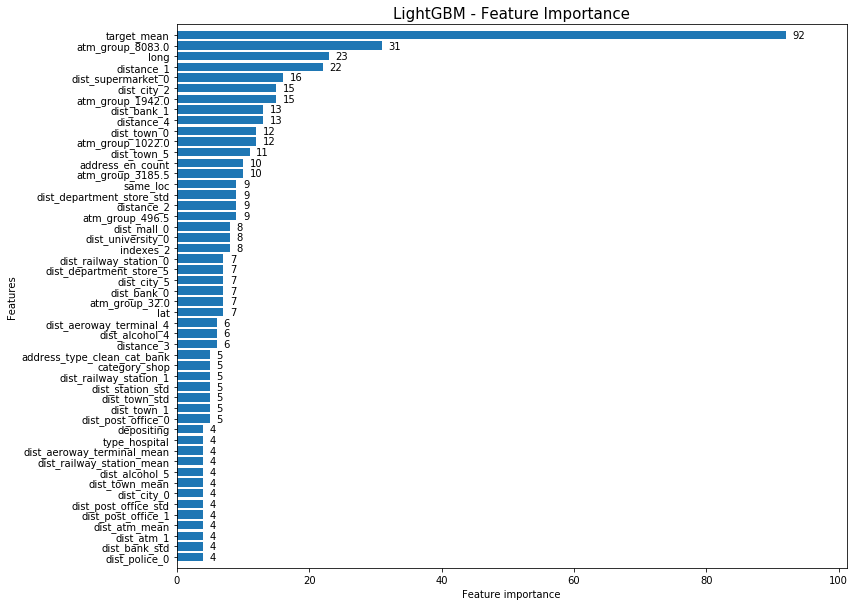

In [94]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(gbm, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [95]:
rmse(Y_valid, gbm.predict(X_valid))

0.04095012402151983

In [96]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.09177255578240429

In [97]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index,columns=['target'])

ValueError: Shape of passed values is (1, 2812), indices imply (1, 2504)

In [ ]:
submit.to_csv('../workspace/submit.csv')